인공지능기초 중간대체과제: 간단한 컨볼루션 신경망(CNN)을 사용하여 이미지 분류 작업 수행

목표: 간단한 컨볼루션 신경망(CNN)과 Fashion-MNIST 데이터셋을 사용하여 이미지 분류 작업을 수행합니다.

환경: Python 3.10.13

1. 초기 환경 구축 및 필요한 라이브러리 추가

In [2]:
#pytorch.py 파일 함수 및 필요한 라이브러리 추가
#!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

#필요한 라이브러리 import
import gzip
import pickle
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import ToTensor

#pytorchcv 라이브러리를 사용하여 Fashion MNIST 데이터셋을 로드하고 전처리한 후 반환
from pytorchcv import load_Fasion_mnist, train, plot_results, plot_convolution, display_dataset
#load_Fasion_mnist(batch_size=128)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


2. Fashion MNIST 데이터셋 로드: Fashion MNIST 데이터셋을 불러온다.

In [3]:
from torchvision.transforms import ToTensor
import builtins

# Fashion MNIST 데이터셋을 로드하는 함수
def load_Fasion_mnist(batch_size=64):
    builtins.train_dataset = torchvision.datasets.FashionMNIST('./data',
        download=True,train=True,transform=ToTensor())
    builtins.test_dataset = torchvision.datasets.FashionMNIST('./data',
        download=True,train=False,transform=ToTensor())
    builtins.train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)
    builtins.test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size)

load_Fasion_mnist()

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



3. 데이터 셋을 훈련용, 테스트용 데이터로 분할 후, 이미지 탐색 및 분석: 데이터 분할 후, 이미지 데이터의 형태와 클래스 레이블을 시작적으로 탐색하고 분석한다.

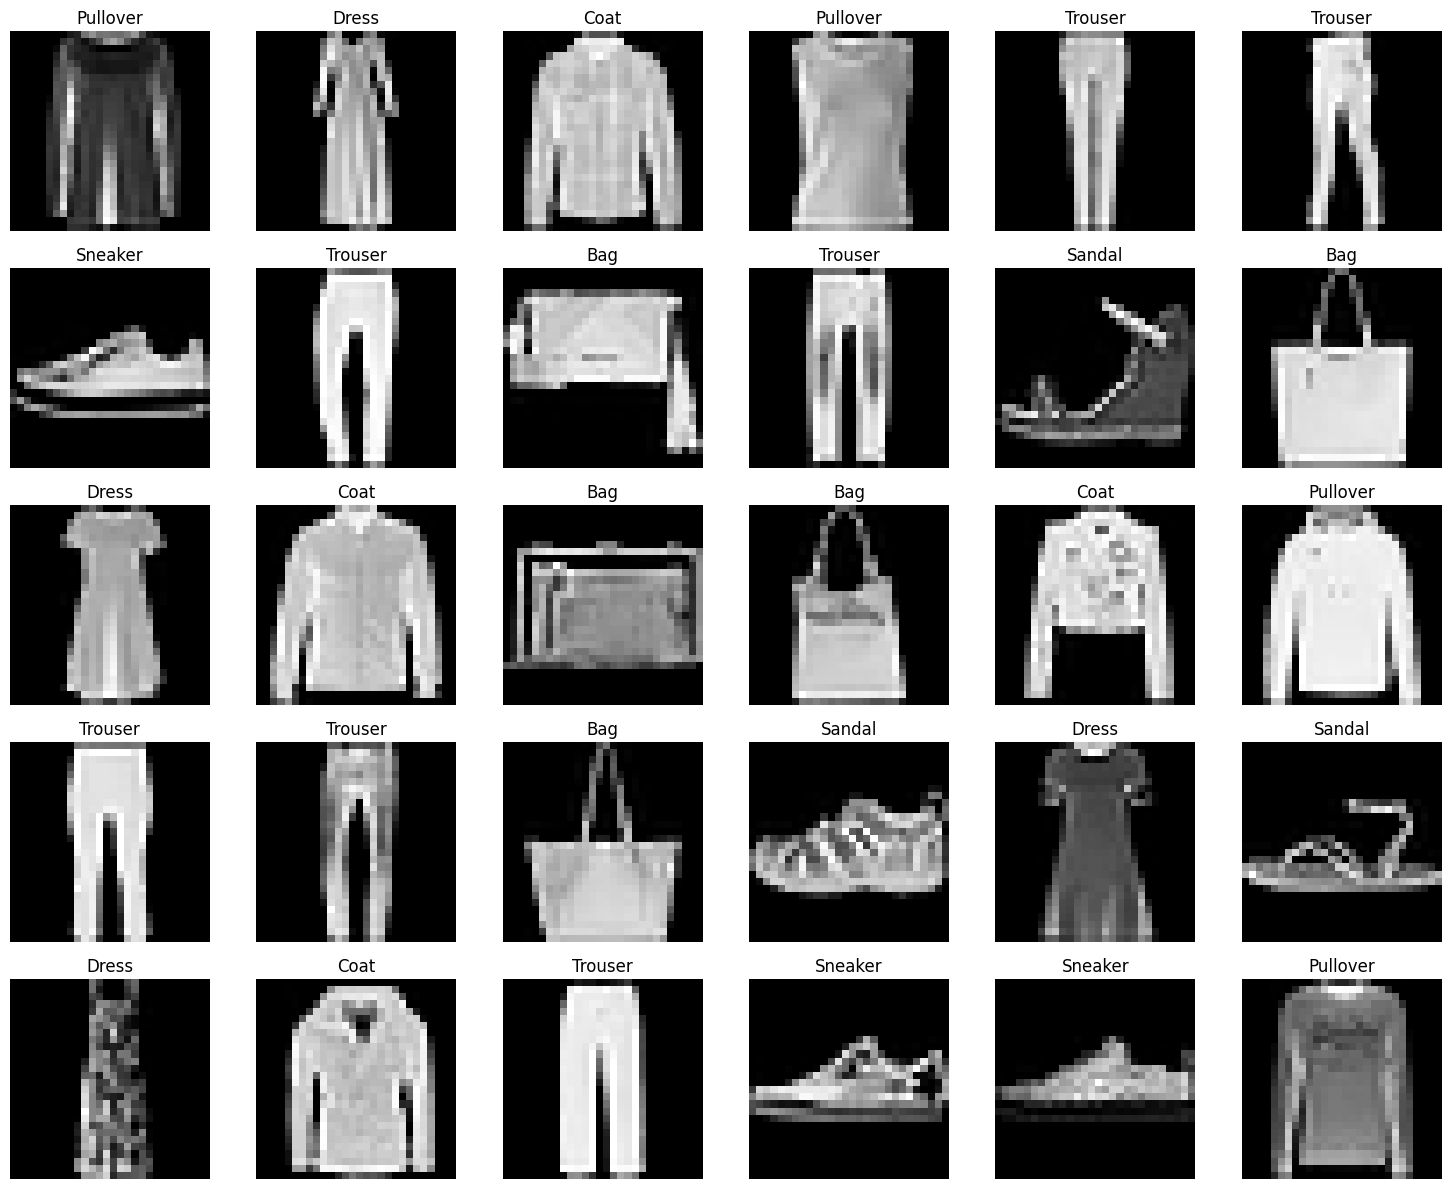

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


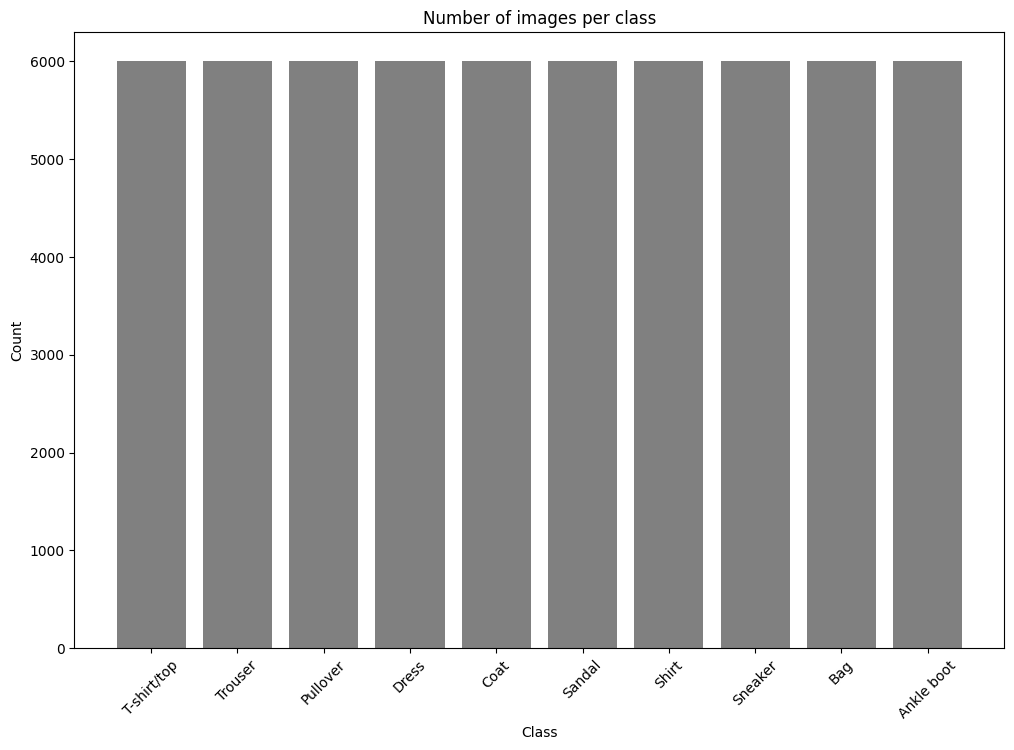

In [4]:
# 데이터를 DataLoader로 분할
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 클래스 레이블 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 이미지 데이터와 레이블 시각적으로 확인
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    idx = torch.randint(len(train_dataset), size=(1,)).item()
    image, label = train_dataset[idx]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

# 클래스 별 학습 데이터 개수 확인
label_counts = {i: 0 for i in range(10)}
for image, label in train_dataset:
    label_counts[label] += 1

print(label_counts)

# 클래스 별 학습 데이터 개수 시각화
plt.figure(figsize=(12, 8))
plt.bar(class_names, label_counts.values(), color='grey')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of images per class')
plt.xticks(rotation=45)
plt.show()

4. cnn 모델 구축(1개의 컨볼루션 레이어, 풀링 레이어 추가): 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의한다.

In [5]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트

class cnn(nn.Module): # nn.Module을 상속받는 cnn라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, cnn 객체가 생성될 때 초기화 과정을 정의
        super(cnn, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)) #풀링레이어 추가
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# 네트워크 인스턴스 생성
net = cnn() # cnn 클래스의 인스턴스를 생성

# 모델의 요약 정보 출력
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


5. 모델 컴파일 후, 적절한 손실 함수와 최적화 알고리즘을 선택: 모델을 학습하고 검증하는 과정 구현 후, 정확도와 손실을 기록하여 진행 상황을 모니터링한다.

In [6]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)

            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

Epoch 1/10: Train Loss: 0.0081, Train Acc: 82.06%, Test Loss: 0.0065, Test Acc: 85.69%
Epoch 2/10: Train Loss: 0.0058, Train Acc: 87.03%, Test Loss: 0.0058, Test Acc: 86.95%
Epoch 3/10: Train Loss: 0.0052, Train Acc: 88.34%, Test Loss: 0.0055, Test Acc: 87.82%
Epoch 4/10: Train Loss: 0.0048, Train Acc: 89.14%, Test Loss: 0.0054, Test Acc: 87.71%
Epoch 5/10: Train Loss: 0.0045, Train Acc: 89.84%, Test Loss: 0.0052, Test Acc: 88.44%
Epoch 6/10: Train Loss: 0.0043, Train Acc: 90.26%, Test Loss: 0.0051, Test Acc: 88.32%
Epoch 7/10: Train Loss: 0.0041, Train Acc: 90.77%, Test Loss: 0.0050, Test Acc: 88.83%
Epoch 8/10: Train Loss: 0.0039, Train Acc: 91.23%, Test Loss: 0.0051, Test Acc: 88.76%
Epoch 9/10: Train Loss: 0.0037, Train Acc: 91.60%, Test Loss: 0.0048, Test Acc: 89.25%
Epoch 10/10: Train Loss: 0.0036, Train Acc: 91.89%, Test Loss: 0.0048, Test Acc: 89.31%


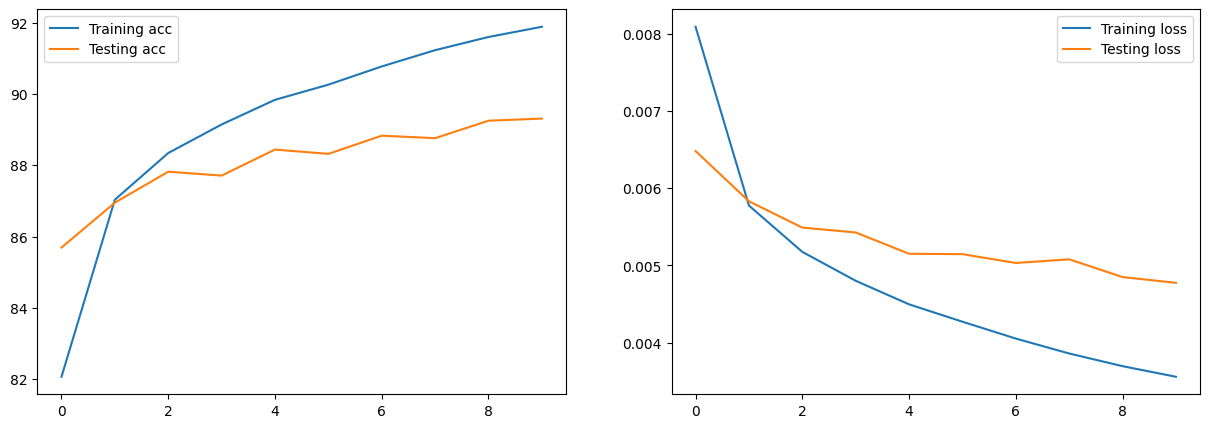

In [7]:
# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 history 변수에 저장
hist = train(net, train_loader, test_loader, epochs=10)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 history가 None이 아니라 유효한 데이터가 있으면
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['test_acc'], label='Testing acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['test_loss'], label='Testing loss')
    plt.legend()


6. 모델 평가 및 결과 분석: 테스트 데이터셋을 사용하여 모델을 평가하고, 최종 정확도를 보고한다.

In [8]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # 모델을 평가 모드로 설정

    correct = 0
    total = 0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # 모델에 이미지 전달하여 예측 얻기
            _, predicted = torch.max(outputs.data, 1)  # 가장 높은 확률을 갖는 클래스 선택
            total += labels.size(0)  # 전체 데이터 수 업데이트
            correct += (predicted == labels).sum().item()  # 정확하게 예측된 데이터 수 업데이트

    accuracy = 100 * correct / total  # 정확도 계산
    print('최종 정확도: {:.2f}%'.format(accuracy))

# 모델 평가
evaluate_model(net, test_loader)


최종 정확도: 89.31%


7. 모델 평가 및 결과 분석: 잘못 분류된 이미지들을 분석하고, 어떤 클래스가 모델에 의해 가장 잘못 분류되었는지를 식별한다.

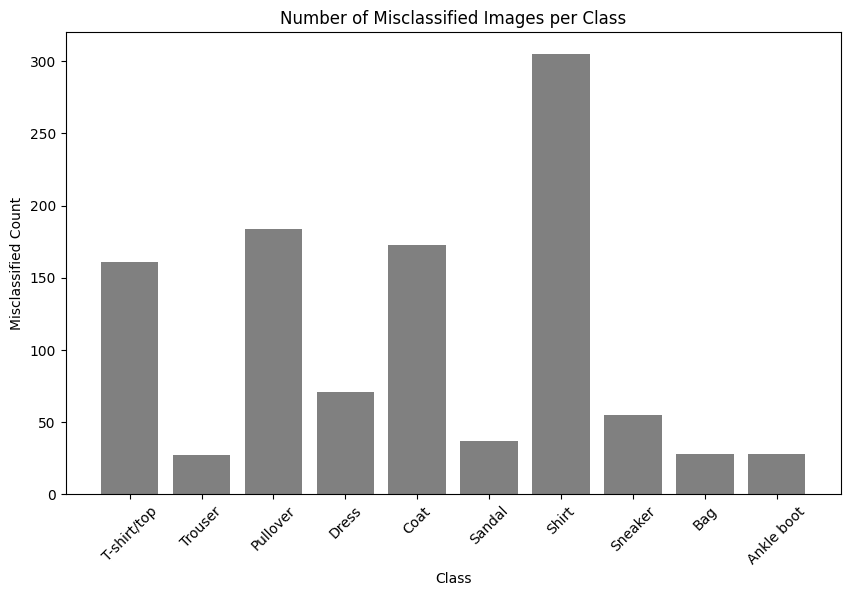

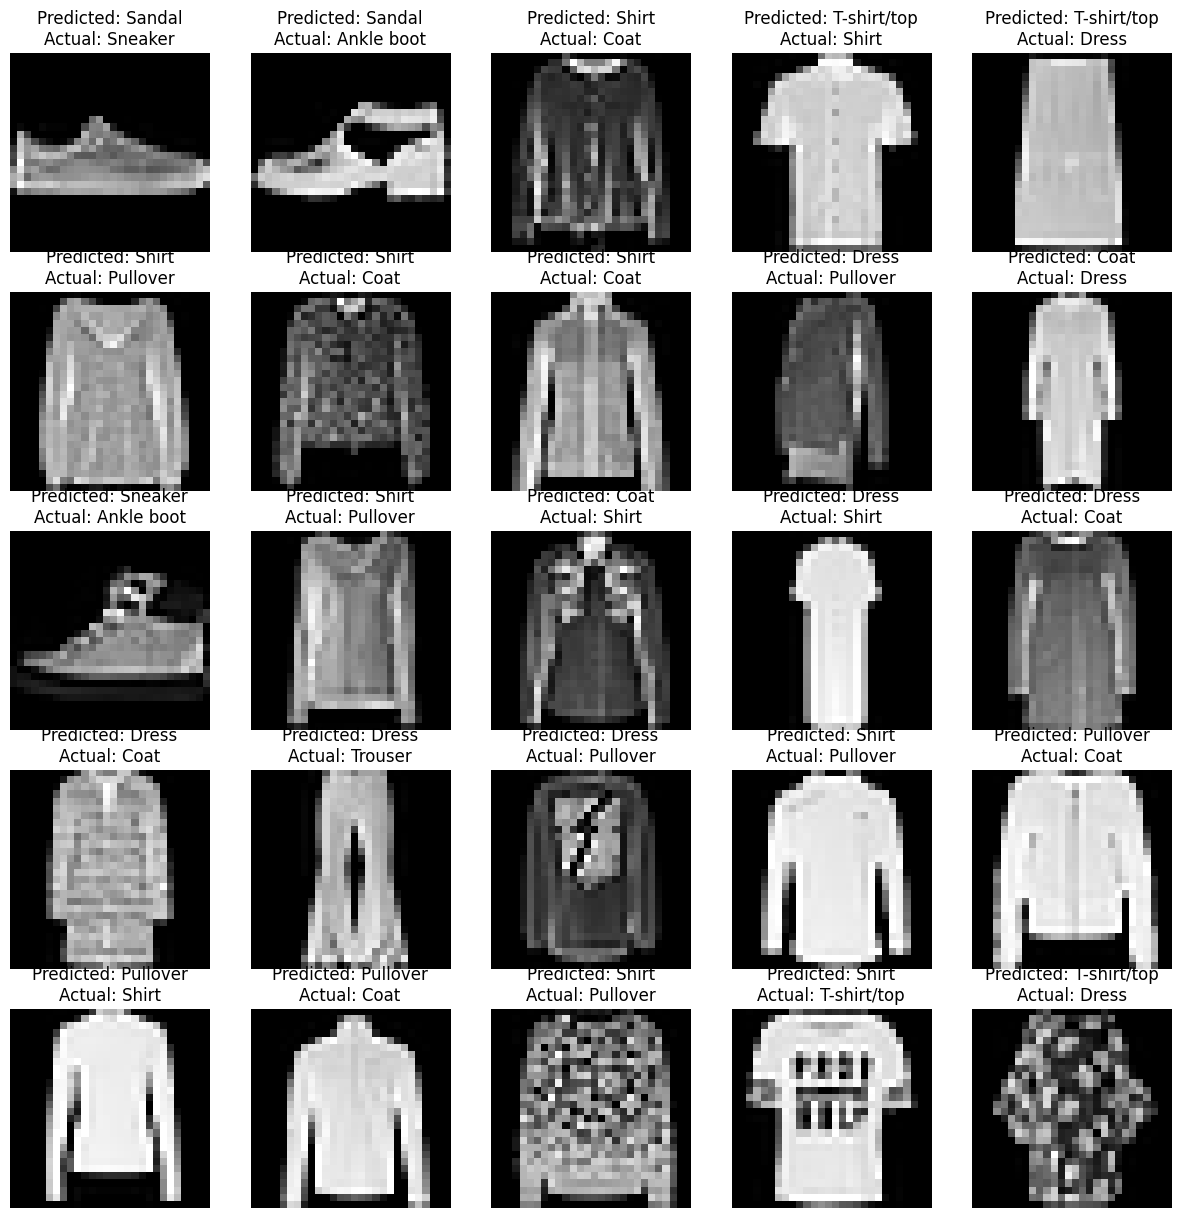

각 클래스별 잘못 분류된 횟수:
T-shirt/top: 161
Trouser: 27
Pullover: 184
Dress: 71
Coat: 173
Sandal: 37
Shirt: 305
Sneaker: 55
Bag: 28
Ankle boot: 28


In [9]:
def analyze_misclassified_images(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # 모델을 평가 모드로 설정

    misclassified_images = []  # 잘못 분류된 이미지들을 저장할 리스트
    misclassified_count = {class_name: 0 for class_name in class_names}  # 각 클래스 별로 잘못 분류된 횟수를 저장할 딕셔너리

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # 모델에 이미지 전달하여 예측 얻기
            _, predicted = torch.max(outputs.data, 1)  # 가장 높은 확률을 갖는 클래스 선택

            # 실제 레이블과 예측 레이블이 다른 경우를 찾음
            misclassified_indices = (predicted != labels).nonzero()[:, 0]
            for index in misclassified_indices:
                misclassified_images.append((images[index], predicted[index], labels[index]))
                misclassified_count[class_names[labels[index].item()]] += 1

    # 각 클래스 별로 잘못 분류된 횟수를 막대 그래프로 시각화
    visualize_misclassified_counts(misclassified_count)

    # 잘못 분류된 이미지들 출력
    plt.figure(figsize=(15, 15))
    for i, (image, predicted, label) in enumerate(misclassified_images[:25]):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image.cpu().squeeze(), cmap='gray')
        plt.title(f'Predicted: {class_names[predicted.item()]}\nActual: {class_names[label.item()]}')
        plt.axis('off')
    plt.show()

    # 각 클래스 별로 잘못 분류된 횟수 출력
    print("각 클래스별 잘못 분류된 횟수:")
    for class_name, count in misclassified_count.items():
        print(f"{class_name}: {count}")

def visualize_misclassified_counts(misclassified_count):
    class_names = list(misclassified_count.keys())
    misclassified_counts = list(misclassified_count.values())

    plt.figure(figsize=(10, 6))
    plt.bar(class_names, misclassified_counts, color='grey')
    plt.xlabel('Class')
    plt.ylabel('Misclassified Count')
    plt.title('Number of Misclassified Images per Class')
    plt.xticks(rotation=45)
    plt.show()

# 잘못 분류된 이미지들을 분석하여 잘못 분류된 횟수를 시각화하고, 잘못 분류된 이미지들을 출력
analyze_misclassified_images(net, test_loader, class_names)

